## Fine-tune DINOv2 with LoRA

In [1]:
!conda install ipykernel
!python -m ipykernel install --user --name=sarl_env_xformers --display-name "Python (sarl_env_xformers)"

Channels:
 - defaults
 - anaconda
Platform: linux-64
Solving environment: done

# All requested packages already installed.

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Installed kernelspec sarl_env_xformers in /root/.local/share/jupyter/kernels/sarl_env_xformers


In [2]:
!pip install torch torchvision torchinfo timm einops peft evaluate ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import requests
from PIL import ImageFile
from pathlib import Path
from zipfile import ZipFile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import VisionDataset, ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.models
from torchinfo import summary
import timm
from lora_vit.lora import LoRA_ViT_timm
import sys

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_dir = f"/workspace/geopacha/data/region1_data/train"
test_dir = f"/workspace/geopacha/data/region1_data/test"
val_dir = f"/workspace/geopacha/data/region1_data/valid"
working_dir = f"/workspace/geopacha/jn"
num_workers = 0
learning_rate = 5e-3
max_epochs_stop = 3
print_every = 1

In [17]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
%load_ext dotenv
%dotenv

In [5]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential

Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Set up data and DINOv2 for finetuning

### Load data

In [6]:
os.chdir('/workspace/geopacha')

image_transformations = {
    'train': transforms.Compose([
        torchvision.transforms.Resize(size=(196, 196), antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        torchvision.transforms.Resize(size=(196, 196), antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        torchvision.transforms.Resize(size=(196, 196), antialias=False),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

class GeoPACHAImageDataset(VisionDataset):
    def __init__(self, data_dir, data_file, transform=None):
        super().__init__(root=data_dir, transform=transform)  # Initialize the base VisionDataset
        self.data_dir = data_dir
        df = pd.read_csv(data_file, delimiter=",")
        self.image_paths = df['img_path']
        self.labels = df['label']
        self.transform = transform

        # Create the class_to_idx dictionary
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(self.labels.unique()))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        # Load image
        image = np.load(img_path)
        # If image has more than 3 channels, take only the first 3 channels (RGB)
        if image.shape[0] > 3:
            image = image[:3]
        # Convert image to tensor
        image = torch.from_numpy(image)
        if self.transform:
            image = self.transform(image)
        # Get label and convert to index using class_to_idx
        label = self.class_to_idx[self.labels[idx]]
        # label = self.labels[idx]

        return image, label
    
datasets = {
    'train': GeoPACHAImageDataset(data_dir=train_dir, data_file='data/region1_data/train_clean.csv', transform=image_transformations['train']),
    'test': GeoPACHAImageDataset(data_dir=test_dir, data_file='data/region1_data/test_clean.csv', transform=image_transformations['test']),
    'validation': GeoPACHAImageDataset(data_dir=val_dir, data_file='data/region1_data/valid_clean.csv', transform=image_transformations['validation'])
}

## Add LoRA to DINOv2

### Init DINOv2 model

In [ ]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_lc', pretrained=True)

# Freeze all layers except the classification head
for name, param in model.named_parameters():
    if 'linear_head' not in name:  
        param.requires_grad = False

# check if all parameters are frozen except the heads
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} trainable: {param.requires_grad}")

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(
        f"trainable params: {total_trainable_params} || all params: {total_params} || trainable%: {100 * total_trainable_params / total_params:.2f}"
    )

# Set the in_ and out_features of the linear head for binary classification
model.linear_head.in_features = 1024
model.linear_head.out_features = 2
model.linear_head

model.class_to_idx = datasets['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Move the model to GPU
model = model.cuda()  

### Set up LoRA model to model

In [8]:
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

In [9]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["linear_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 5514216 || all params: 315003856 || trainable%: 1.75


Check the trainable parameters from applying LoRA

In [11]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.backbone.blocks.0.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.0.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.1.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.1.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.2.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.2.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.3.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.3.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.4.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.4.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.5.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.5.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.6.attn.qkv.lora_A.default.weight
base_model.model.backbone.blocks.6.attn.qkv.lora_B.default.weight
base_model.model.backbone.blocks.7.attn.qkv.lora_A.default.weight
base_model

In [131]:
lora_model

PeftModel(
  (base_model): LoraModel(
    (model): _LinearClassifierWrapper(
      (backbone): DinoVisionTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
          (norm): Identity()
        )
        (blocks): ModuleList(
          (0-23): 24 x NestedTensorBlock(
            (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (attn): MemEffAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3072, bias=False)
                )
                (lora_embedding_A)

Starting Training.

Class 0 - Train Accuracy: 0.01, Validation Accuracy: 0.12
Class 1 - Train Accuracy: 0.36, Validation Accuracy: 0.94
Epoch 1: Total Train Acc: 0.18, Total Valid Acc: 0.19
Training Loss: 4.9064, Validation Loss: 2.0788

Epoch: 1 	Training Loss: 7835.4845 	Validation Loss: 2598.4927
		Training Accuracy: 18.41%	 Validation Accuracy: 19.12%
Class 0 - Train Accuracy: 0.58, Validation Accuracy: 0.79
Class 1 - Train Accuracy: 0.62, Validation Accuracy: 0.43
Epoch 2: Total Train Acc: 0.60, Total Valid Acc: 0.76
Training Loss: 0.8807, Validation Loss: 0.4847

Epoch: 2 	Training Loss: 1406.5256 	Validation Loss: 605.8995
		Training Accuracy: 59.74%	 Validation Accuracy: 76.16%
Class 0 - Train Accuracy: 0.65, Validation Accuracy: 0.66
Class 1 - Train Accuracy: 0.72, Validation Accuracy: 0.73
Epoch 3: Total Train Acc: 0.69, Total Valid Acc: 0.67
Training Loss: 0.6177, Validation Loss: 0.6379

Epoch: 3 	Training Loss: 986.4526 	Validation Loss: 797.4050
		Training Accuracy: 68.69

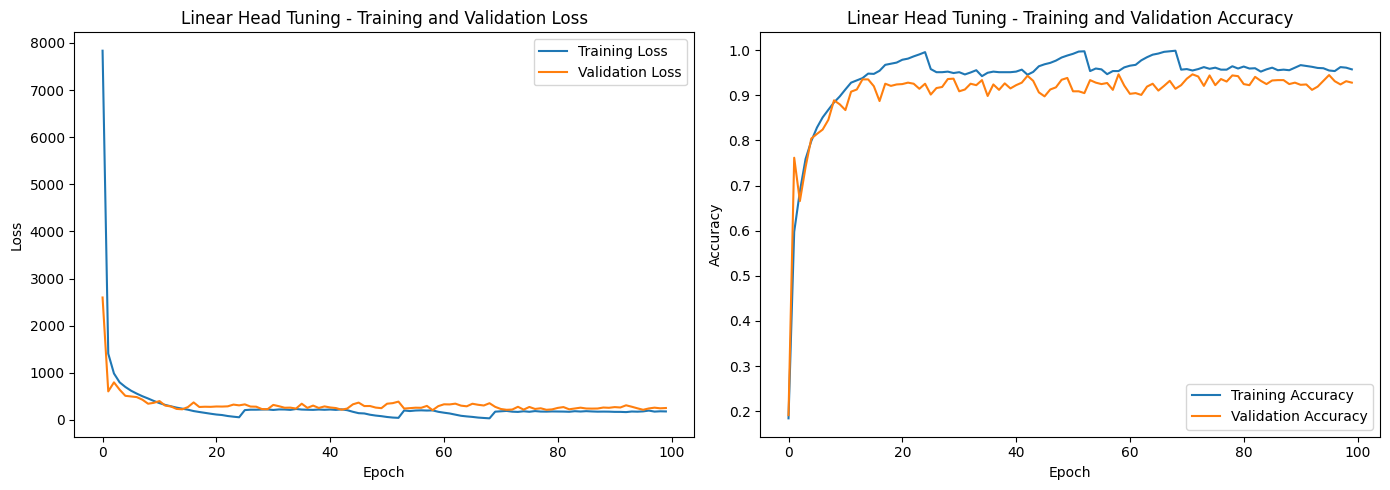

In [15]:
n_epochs = 100
num_classes = 2

# Initialize dictionaries to track per-class metrics
class_correct_train = {i: 0 for i in range(num_classes)}
class_total_train = {i: 0 for i in range(num_classes)}
class_correct_valid = {i: 0 for i in range(num_classes)}
class_total_valid = {i: 0 for i in range(num_classes)}

learning_rate = 0.0001
batch_size = 128
# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf
valid_max_acc = 0
max_epochs_stop = 10
history = []
save_model_file_name = f'/workspace/geopacha/jn/model/dinov2_vitl14_lc_state_dict_lora_{n_epochs}e_{batch_size}b.pt'
# save_model_file_name = f'TEST.pth'

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'validation': torch.utils.data.DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, lora_model.parameters()), lr=learning_rate)

# Number of epochs already trained (if using loaded in lora_model weights)
try:
    print(f'Model has been trained for: {lora_model.epochs} epochs.\n')
except:
    lora_model.epochs = 0
    print(f'Starting Training.\n')

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

lora_model.cuda()

for epoch in range(n_epochs):
    # Reset training and validation metrics at the start of each epoch
    train_loss, valid_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0
    class_correct_train = {i: 0 for i in range(num_classes)}
    class_total_train = {i: 0 for i in range(num_classes)}
    class_correct_valid = {i: 0 for i in range(num_classes)}
    class_total_valid = {i: 0 for i in range(num_classes)}

    lora_model.train()
    for data, target in dataloaders['train']:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = lora_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        for i in range(num_classes):
            correct = (preds == target)
            class_correct_train[i] += correct[target == i].sum().item()
            class_total_train[i] += (target == i).sum().item()

    # Validation phase
    lora_model.eval()
    with torch.no_grad():
        for data, target in dataloaders['validation']:
            data, target = data.cuda(), target.cuda()
            output = lora_model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            for i in range(num_classes):
                correct = (preds == target)
                class_correct_valid[i] += correct[target == i].sum().item()
                class_total_valid[i] += (target == i).sum().item()

    # Calculate and print per-class accuracies
    train_acc_class_0 = (class_correct_train[0] / class_total_train[0]) if class_total_train[0] > 0 else 0
    valid_acc_class_0 = (class_correct_valid[0] / class_total_valid[0]) if class_total_valid[0] > 0 else 0
    print(f'Class 0 - Train Accuracy: {train_acc_class_0:.2f}, Validation Accuracy: {valid_acc_class_0:.2f}')
    train_acc_class_1 = (class_correct_train[1] / class_total_train[1]) if class_total_train[1] > 0 else 0
    valid_acc_class_1 = (class_correct_valid[1] / class_total_valid[1]) if class_total_valid[1] > 0 else 0
    print(f'Class 1 - Train Accuracy: {train_acc_class_1:.2f}, Validation Accuracy: {valid_acc_class_1:.2f}')


    # Overall metrics for the epoch
    total_train_acc = sum(class_correct_train.values()) / sum(class_total_train.values())
    total_valid_acc = sum(class_correct_valid.values()) / sum(class_total_valid.values())
    print(f'Epoch {epoch + 1}: Total Train Acc: {total_train_acc:.2f}, Total Valid Acc: {total_valid_acc:.2f}')
    print(f'Training Loss: {train_loss/len(dataloaders["train"].dataset):.4f}, Validation Loss: {valid_loss/len(dataloaders["validation"].dataset):.4f}')

    history.append([train_loss, 
                    valid_loss, 
                    total_train_acc, 
                    total_valid_acc, 
                    train_acc_class_0,
                    train_acc_class_1])

    # Print training and validation results
    if (epoch + 1) % print_every == 0:
        print(f'\nEpoch: {epoch + 1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * total_train_acc:.2f}%\t Validation Accuracy: {100 * total_valid_acc:.2f}%')

    # Save the model if validation loss decreases
    if valid_loss < valid_loss_min:
        # Save model
        torch.save(lora_model.state_dict(), save_model_file_name)
        # Track improvement
        epochs_no_improve = 0
        valid_loss_min = valid_loss
        valid_best_acc = valid_acc
        best_epoch = epoch
    # Otherwise increment count of epochs with no improvement
    else:
        epochs_no_improve += 1
        # Trigger early stopping
        if epochs_no_improve >= max_epochs_stop:
            print(
                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
            )
            # Load the best state dict
            lora_model.load_state_dict(torch.load(save_model_file_name))

            # Attach the optimizer
            lora_model.optimizer = optimizer


end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)

print("") 
print("Inferencing complete.")
print("Elapsed time: ", elapsed_time_ms)

# Save the model
torch.save(lora_model.state_dict(), save_model_file_name)

# Format history
history_df = pd.DataFrame(history, columns=['train_loss', 
                                            'valid_loss', 
                                            'train_acc', 
                                            'valid_acc', 
                                            'train_acc_class_0',
                                            'train_acc_class_1'])

# Save the history object to a pickle file
history_filename = f'/workspace/geopacha/jn/model/training_history_dinov2_vitl14_lc_lora_{n_epochs}e_{batch_size}b.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history_df, f)

print(f'Training history saved to {history_filename}')

f_name = f"dinov2_vitl14_lc_lora_{n_epochs}e{batch_size}b.png"
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Training Loss')
plt.plot(history_df['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LoRA Fine-Tuning - Training and Validation Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Training Accuracy')
plt.plot(history_df['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LoRA Fine-Tuning - Training and Validation Accuracy')
plt.legend()

# Save the plot to a file
plt.tight_layout()
plt.savefig(f'{working_dir}/output/{f_name}')
plt.show()

trainable params: 5514216 || all params: 315003856 || trainable%: 1.75
Starting Training.

Class 0 - Train Accuracy: 0.00, Validation Accuracy: 0.02
Class 1 - Train Accuracy: 0.12, Validation Accuracy: 0.77
Epoch 1: Total Train Acc: 0.06, Total Valid Acc: 0.09
Training Loss: 6.2332, Validation Loss: 3.6443

Epoch: 1 	Training Loss: 9954.4065 	Validation Loss: 4555.3601
		Training Accuracy: 0.00%	 Validation Accuracy: 0.00%
Class 0 - Train Accuracy: 0.16, Validation Accuracy: 0.60
Class 1 - Train Accuracy: 0.86, Validation Accuracy: 0.61
Epoch 2: Total Train Acc: 0.51, Total Valid Acc: 0.60
Training Loss: 1.4933, Validation Loss: 0.7990

Epoch: 2 	Training Loss: 2384.7342 	Validation Loss: 998.7607
		Training Accuracy: 0.00%	 Validation Accuracy: 0.00%
Class 0 - Train Accuracy: 0.81, Validation Accuracy: 0.78
Class 1 - Train Accuracy: 0.43, Validation Accuracy: 0.51
Epoch 3: Total Train Acc: 0.62, Total Valid Acc: 0.75
Training Loss: 0.7774, Validation Loss: 0.4995

Epoch: 3 	Training L

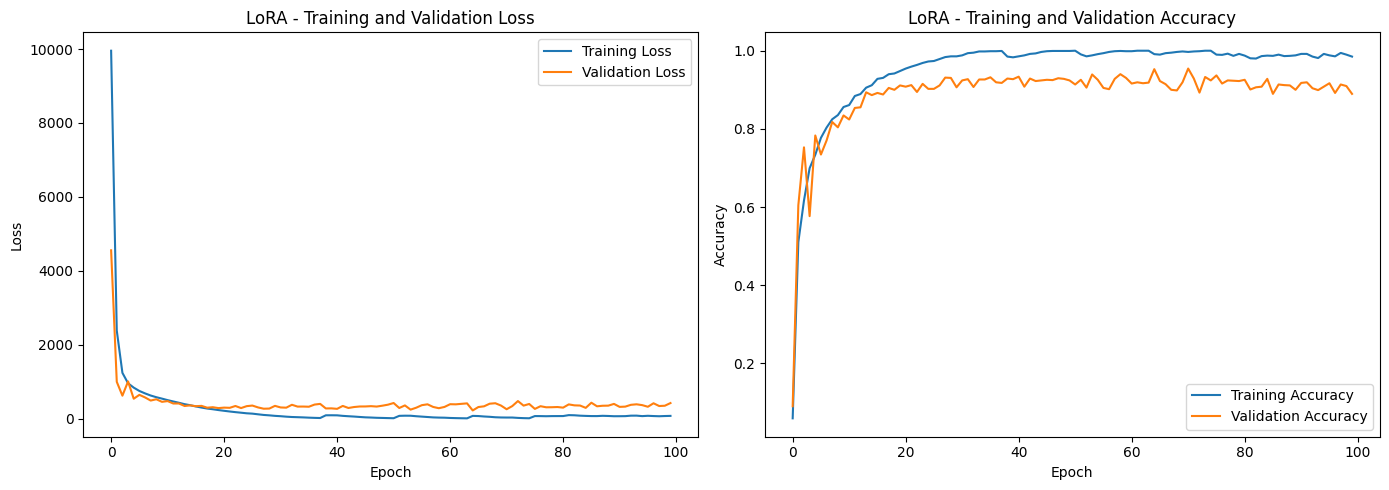

In [19]:
import numpy as np
from collections import defaultdict
import torch
from torch import nn, optim
from tqdm import tqdm
import sys

n_epochs = 100
num_classes = 2
# increase batch_size
batch_size = 192

# Reinit lora_model
config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["linear_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

# Initialize dictionaries to track per-class metrics
class_correct_train = {i: 0 for i in range(num_classes)}
class_total_train = {i: 0 for i in range(num_classes)}
class_correct_valid = {i: 0 for i in range(num_classes)}
class_total_valid = {i: 0 for i in range(num_classes)}

learning_rate = 0.0001
# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf
valid_max_acc = 0
max_epochs_stop = 10
history = []
save_model_file_name = f'/workspace/geopacha/jn/model/dinov2_vitl14_lc_lora_state_dict_{n_epochs}e_{batch_size}b.pt'

# Set dataloader w/ batch size
dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'validation': torch.utils.data.DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, lora_model.parameters()), lr=learning_rate)

# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {lora_model.epochs} epochs.\n')
except:
    lora_model.epochs = 0
    print(f'Starting Training.\n')

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

for epoch in range(n_epochs):
    # Reset training and validation metrics at the start of each epoch
    train_loss, valid_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0
    class_correct_train = {i: 0 for i in range(num_classes)}
    class_total_train = {i: 0 for i in range(num_classes)}
    class_correct_valid = {i: 0 for i in range(num_classes)}
    class_total_valid = {i: 0 for i in range(num_classes)}

    lora_model.train()
    for data, target in dataloaders['train']:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = lora_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        for i in range(num_classes):
            correct = (preds == target)
            class_correct_train[i] += correct[target == i].sum().item()
            class_total_train[i] += (target == i).sum().item()

    # Validation phase
    lora_model.eval()
    with torch.no_grad():
        for data, target in dataloaders['validation']:
            data, target = data.cuda(), target.cuda()
            output = lora_model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            for i in range(num_classes):
                correct = (preds == target)
                class_correct_valid[i] += correct[target == i].sum().item()
                class_total_valid[i] += (target == i).sum().item()

    # Calculate and print per-class accuracies
    train_acc_class_0 = (class_correct_train[0] / class_total_train[0]) if class_total_train[0] > 0 else 0
    valid_acc_class_0 = (class_correct_valid[0] / class_total_valid[0]) if class_total_valid[0] > 0 else 0
    print(f'Class 0 - Train Accuracy: {train_acc_class_0:.2f}, Validation Accuracy: {valid_acc_class_0:.2f}')
    train_acc_class_1 = (class_correct_train[1] / class_total_train[1]) if class_total_train[1] > 0 else 0
    valid_acc_class_1 = (class_correct_valid[1] / class_total_valid[1]) if class_total_valid[1] > 0 else 0
    print(f'Class 1 - Train Accuracy: {train_acc_class_1:.2f}, Validation Accuracy: {valid_acc_class_1:.2f}')


    # Overall metrics for the epoch
    total_train_acc = sum(class_correct_train.values()) / sum(class_total_train.values())
    total_valid_acc = sum(class_correct_valid.values()) / sum(class_total_valid.values())
    print(f'Epoch {epoch + 1}: Total Train Acc: {total_train_acc:.2f}, Total Valid Acc: {total_valid_acc:.2f}')
    print(f'Training Loss: {train_loss/len(dataloaders["train"].dataset):.4f}, Validation Loss: {valid_loss/len(dataloaders["validation"].dataset):.4f}')

    history.append([train_loss, 
                    valid_loss, 
                    total_train_acc, 
                    total_valid_acc, 
                    train_acc_class_0,
                    train_acc_class_1])

    # Print training and validation results
    if (epoch + 1) % print_every == 0:
        print(f'\nEpoch: {epoch + 1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

    # Save the model if validation loss decreases
    if valid_loss < valid_loss_min:
        # Save model
        torch.save(lora_model.state_dict(), save_model_file_name)
        # Track improvement
        epochs_no_improve = 0
        valid_loss_min = valid_loss
        valid_best_acc = valid_acc
        best_epoch = epoch
    # Otherwise increment count of epochs with no improvement
    else:
        epochs_no_improve += 1
        # Trigger early stopping
        if epochs_no_improve >= max_epochs_stop:
            print(
                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
            )
            # Load the best state dict
            lora_model.load_state_dict(torch.load(save_model_file_name))

            # Attach the optimizer
            lora_model.optimizer = optimizer


end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)

print("") 
print("Inferencing complete.")
print("Elapsed time: ", elapsed_time_ms)

# Save the model
torch.save(lora_model.state_dict(), save_model_file_name)

# Format history
history_df = pd.DataFrame(history, columns=['train_loss', 
                                            'valid_loss', 
                                            'train_acc', 
                                            'valid_acc', 
                                            'train_acc_class_0',
                                            'train_acc_class_1'])

# Save the history object to a pickle file
history_filename = f'/workspace/geopacha/jn/model/training_history_dinov2_vitl14_lc_lora_{n_epochs}e_{batch_size}b.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history_df, f)

print(f'Training history saved to {history_filename}')

f_name = f"dinov2_vitl14_lc_lora_{n_epochs}e_{batch_size}b.png"
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Training Loss')
plt.plot(history_df['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LoRA - Training and Validation Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Training Accuracy')
plt.plot(history_df['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LoRA - Training and Validation Accuracy')
plt.legend()

# Save the plot to a file
plt.tight_layout()
plt.savefig(f'{working_dir}/output/{f_name}')
plt.show()